# USAD

## Environment

In [1]:
import os

NORMAL_FILENAME = "CPU_Usage-NORMALv1.csv"
ATTACK_FILENAME = "CPU_Usage-OVERALL_ATTACKv1.csv"
if os.path.basename(os.getcwd()) != 'usad':
    !rm -r sample_data
    !git clone https://github.com/manigalati/usad
    %cd usad
    !mkdir input
    !python gdrivedl.py https://drive.google.com/file/d/1bkLmu3gf0bCFL6UESqrFX70A9VifJfdw/view?usp=sharing input/  # normal v2
    !python gdrivedl.py https://drive.google.com/file/d/1c3ZrrpLn9HxP-mlkxiSxlHEYLnA-0hph/view?usp=sharing input  # overall attack v2


Cloning into 'usad'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 99 (delta 31), reused 28 (delta 28), pack-reused 61
Receiving objects: 100% (99/99), 2.81 MiB | 29.07 MiB/s, done.
Resolving deltas: 100% (47/47), done.
/content/usad
input/CPU_Usage-NORMAL.csv
[==================================================] 11.27MB/11.27MB
input/CPU_Usage-OVERALL_ATTACK.csv
[==================================================] 1.25MB/1.25MB


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

from utils import *
from usad import *

In [3]:
!nvidia-smi -L

device = get_default_device()

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-05a0edb2-ff95-d9de-bf63-e06829b2b1b9)


## EDA - Data Pre-Processing

### Normal period

In [4]:
#Read data
normal = pd.read_csv(f"input/{NORMAL_FILENAME}")
normal = normal.drop(["timestamp", "label"] , axis = 1)
normal.shape

(52560, 10)

In [5]:
# Transform all columns into float64
normal = normal.astype(float)

#### Normalization

In [6]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

In [7]:
normal.head(2)

,0,1,2,3,4,5,6,7,8,9
0,0.371064,0.323768,0.084841,0.200586,0.529127,0.310969,0.386448,0.560211,0.430091,0.146702
1,0.371064,0.315808,0.100613,0.200586,0.484639,0.310969,0.386448,0.560211,0.369480,0.146702


### Attack

In [8]:
#Read data
attack = pd.read_csv(f"input/{ATTACK_FILENAME}")#, nrows=1000)
labels = [ float(label) for label in attack["label"].values]  # TypeError: only size-1 arrays can be converted to Python scalars
attack = attack.drop(["timestamp", "label"] , axis = 1)
attack.shape

(5754, 10)

In [9]:
# Transform all columns into float64
attack = attack.astype(float)

#### Normalization

In [10]:
from sklearn import preprocessing

x = attack.values
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)

In [11]:
attack.head(2)

,0,1,2,3,4,5,6,7,8,9
0,0.119522,0.918958,0.005548,1.262749,0.016506,1.278997,0.017592,0.775037,0.100976,0.00545
1,0.119522,1.239975,0.005548,1.262749,0.016506,1.278997,0.017592,0.775037,0.100976,0.00545


### Windows

In [12]:
window_size=12

In [13]:
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_normal.shape

(52548, 12, 10)

In [14]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(5742, 12, 10)

## Training

In [15]:
import torch.utils.data as data_utils

BATCH_SIZE = 792
N_EPOCHS = 100
hidden_size = 100

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [16]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss1: 0.0188, val_loss2: 0.0189
Epoch [1], val_loss1: 0.0188, val_loss2: 0.0002
Epoch [2], val_loss1: 0.0185, val_loss2: -0.0061
Epoch [3], val_loss1: 0.0186, val_loss2: -0.0093
Epoch [4], val_loss1: 0.0187, val_loss2: -0.0112
Epoch [5], val_loss1: 0.0193, val_loss2: -0.0129
Epoch [6], val_loss1: 0.0186, val_loss2: -0.0133
Epoch [7], val_loss1: 0.0186, val_loss2: -0.0139
Epoch [8], val_loss1: 0.0187, val_loss2: -0.0145
Epoch [9], val_loss1: 0.0187, val_loss2: -0.0149
Epoch [10], val_loss1: 0.0188, val_loss2: -0.0154
Epoch [11], val_loss1: 0.0188, val_loss2: -0.0157
Epoch [12], val_loss1: 0.0187, val_loss2: -0.0158
Epoch [13], val_loss1: 0.0188, val_loss2: -0.0161
Epoch [14], val_loss1: 0.0189, val_loss2: -0.0163
Epoch [15], val_loss1: 0.0189, val_loss2: -0.0165
Epoch [16], val_loss1: 0.0189, val_loss2: -0.0167
Epoch [17], val_loss1: 0.0189, val_loss2: -0.0168
Epoch [18], val_loss1: 0.0188, val_loss2: -0.0168
Epoch [19], val_loss1: 0.0189, val_loss2: -0.0170
Epoch [20], 

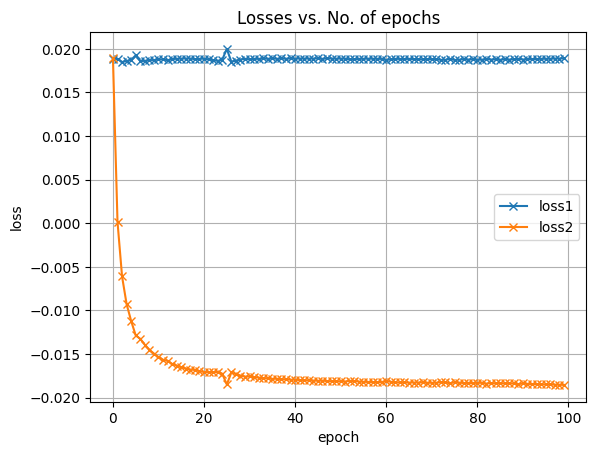

In [17]:
plot_history(history)

In [18]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")

## Testing

In [19]:
checkpoint = torch.load("model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [20]:
results=testing(model,test_loader)

In [21]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int_(labels[i:i+window_size])))

In [22]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]

In [23]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

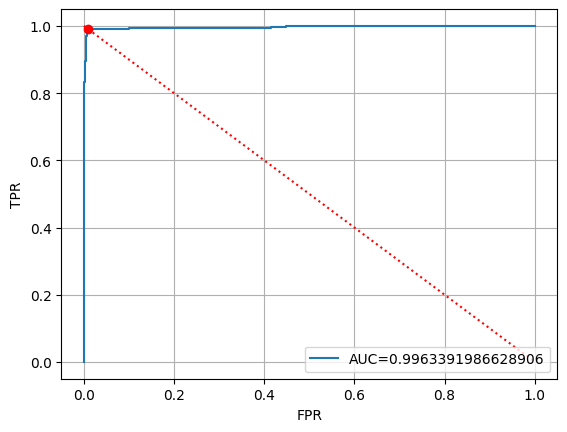

In [24]:
threshold=ROC(y_test,y_pred)